In [1]:
import pandas as pd
import sys
import re
import random
random.seed()
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import lightgbm as lgb
from sklearn import preprocessing
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from scipy import stats
import pylab as pl
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


Bad key "lines.markeredgecolor" on line 12 in
C:\Users\Administrator\AppData\Roaming\Python\Python35\site-packages\matplotlib\mpl-data\stylelib\classic.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution

Bad key "lines.markerfacecolor" on line 11 in
C:\Users\Administrator\AppData\Roaming\Python\Python35\site-packages\matplotlib\mpl-data\stylelib\classic.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Exploratory data analysis

In [2]:
raw_data_df = pd.read_csv("Kaggle_Salary.csv",encoding='utf-8',low_memory=False)
# change the order of columns to let the "index" column be the first column.
cols = raw_data_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
raw_data_df = raw_data_df[cols]
raw_data_df.head()

,index,Unnamed: 0,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,...,Q49_OTHER_TEXT,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT
0,NaN,0,Duration (in seconds),What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe...,What is your age (# years)?,In which country do you currently reside?,What is the highest level of formal education ...,Which best describes your undergraduate major?...,Select the title most similar to your current ...,...,What tools and methods do you use to make your...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...
1,0.0,2,434,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,1.0,3,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,...,-1,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,2.0,5,731,Male,-1,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,...,-1,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1
4,3.0,7,959,Male,-1,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,...,-1,Too expensive,NaN,NaN,NaN,NaN,I had never considered making my work easier f...,NaN,NaN,-1


As we can see in the dataframe, most features should be treated as categorical features. A daunting task on convering them to numerical data, right? Actually, 50% of your data science time is spent on data cleaning. But don't be discouraged because only with data analytics can you derive insights from massive raw data.

Let's take a look at what are current yearly compensations marked by respondents. As we can see, most of the compensations fall in 0-10,000 range. The distribution is positively skewed.

f:\3.5.2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5,1,'the distribution of yearly compensation')

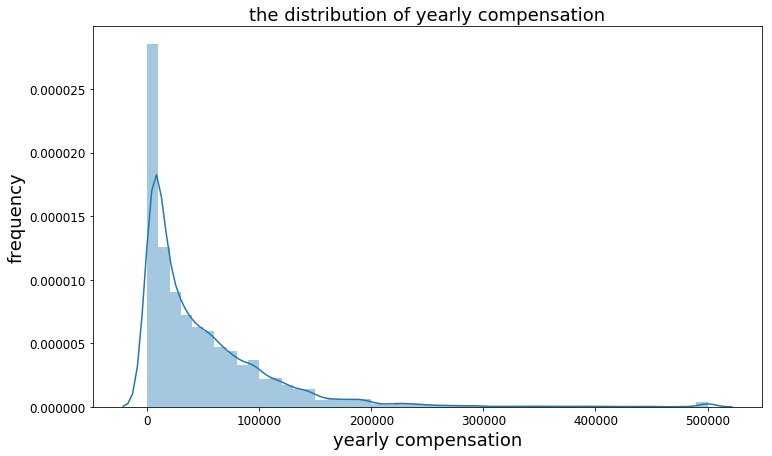

In [3]:
raw_df = raw_data_df.loc[1:, ]
raw_df["Q9"]=raw_df["Q9"].astype('float64')
raw_data_df["Q9"].loc[1:]=raw_data_df["Q9"].loc[1:].astype('float64')
plt.figure(figsize=(12,7))
g=sns.distplot(raw_df['Q9'])
plt.tick_params(labelsize=12) 
plt.xlabel('yearly compensation',size=18)
plt.ylabel('frequency',size=18)
plt.title('the distribution of yearly compensation',size=18)

I'm trying to figure out what are factors affecting Kagglers compensation. For example, which countries have highest compensation? Let's inspect this feature by ploting average salary size by country.

No surprises here as US, Canada and Europe are at the top.

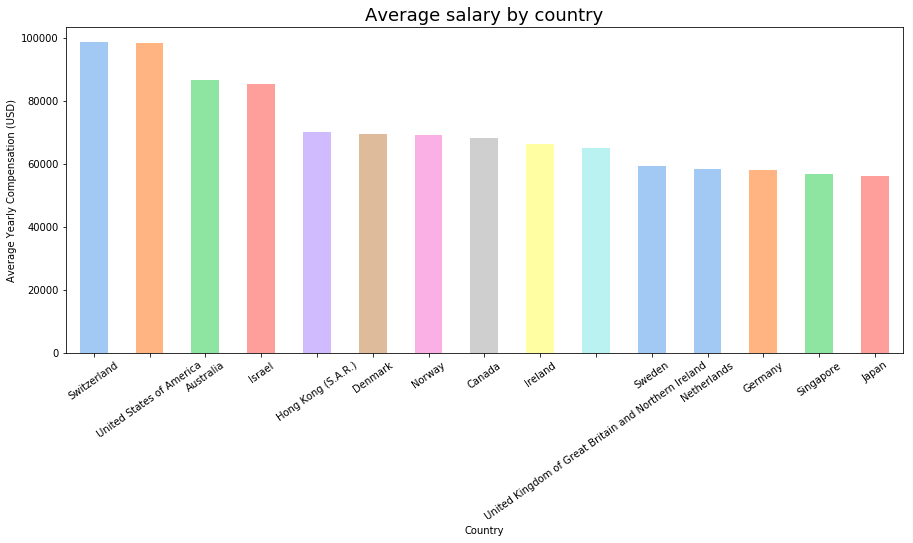

In [4]:
sns.set_palette('pastel')
px = raw_df.groupby(['Q3'])['Q9'].mean().sort_values(ascending=False).head(15).plot(kind="bar", figsize=(15,6))
px.set(xlabel='Country', ylabel='Average Yearly Compensation (USD)')
px.set_xticklabels(px.get_xticklabels(), rotation=35)
plt.title('Average salary by country',size=18)
plt.tick_params(labelsize=10) 

## Job title
Q6:Select the title most similar to your current role (or most recent title if retired): - Selected Choice

Does job title affect your compensation? Let's inspect this feature by ploting boxplots of salary by job title. No surprise as students and research assistants have smaller salary. Chief officiers have higher salary."Data Scientist" seems not to be the only job title for receiving big salary,many other jobs shows way better earning perspectives.

Text(0.5,1,'salary by job title')

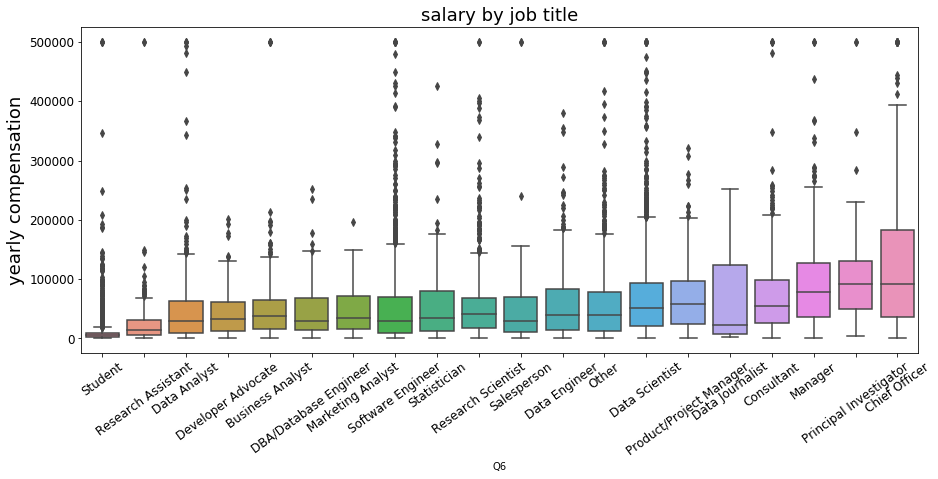

In [5]:
order=raw_df.groupby(['Q6'])['Q9'].mean().sort_values(ascending=True).index #sort values by mean 
plt.figure(figsize=(15,6))
sns.boxplot(x=raw_df["Q6"],y=raw_df["Q9"],order=order)
plt.tick_params(labelsize=12)
pl.xticks(rotation=36)
plt.ylabel('yearly compensation',size=18)
plt.title('salary by job title',size=18)

Do two features have special relationship? Do some certain jobs use machine learning methods more often? Some intereting findings are shown as below. Data scientist and software engineers use ML methods more often while student seem to know little about ML methods. Acutually, you can combine any two or more features together and you will find interesting trends or relationships.

In [6]:
s = pd.crosstab(raw_df['Q6'],
                raw_df['Q10']).style.background_gradient(cmap='viridis', low=.1, high=0).highlight_null('red')
s

Q10,I do not know,No (we do not use ML methods),We are exploring ML methods (and may one day put a model into production),"We have well established ML methods (i.e., models in production for more than 2 years)","We recently started using ML methods (i.e., models in production for less than 2 years)",We use ML methods for generating insights (but do not put working models into production)
Q6,,,,,,
Business Analyst,29,199,158,40,83,73
Chief Officer,6,45,69,50,54,26
Consultant,29,143,157,81,91,67
DBA/Database Engineer,13,49,24,11,14,5
Data Analyst,71,346,369,157,257,205
Data Engineer,16,84,158,89,150,62
Data Journalist,0,4,0,1,2,3
Data Scientist,101,127,583,866,1097,439
Developer Advocate,2,34,25,7,8,7


### Cleanup unneeded data
students belong to a particular group in that they may have a part time job and students are not allowed to work in some countries so their salary data are unneeded. Feature importances will be shown after data cleaning.

# Data cleaning

In [7]:
raw_data_df = raw_data_df[raw_data_df.Q6 != 'Student']
raw_data_df = raw_data_df[raw_data_df.Q7 != 'I am a student']

### Checking the missing data for all columns. 
Following is a heatmap that shows the distribution of missing data in the dataset. Yellow represents as missing data.

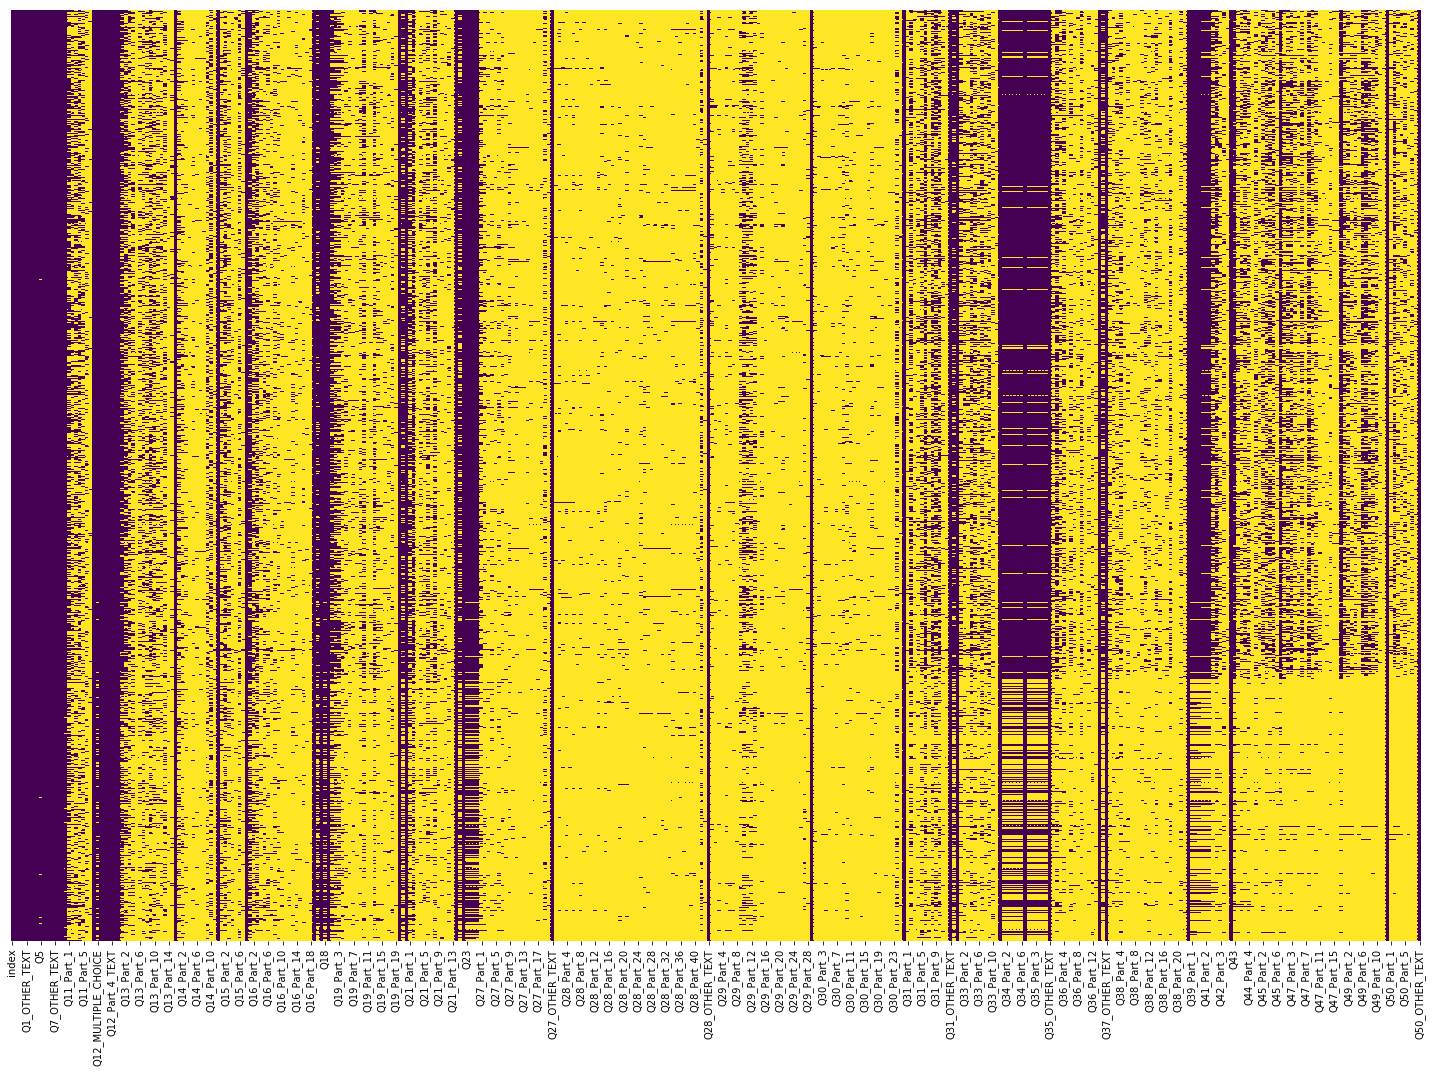

In [8]:
plt.figure(figsize=(20,15))
sns.heatmap(raw_data_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.tight_layout()
plt.show()

In [9]:
raw_data_df.filter(regex='Q13_Part').head()

,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,Q13_Part_12,Q13_Part_13,Q13_Part_14,Q13_Part_15
0,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
4,NaN,RStudio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Jupyter/IPython,NaN,PyCharm,NaN,NaN,Atom,NaN,Visual Studio,Notepad++,Sublime Text,NaN,IntelliJ,Spyder,NaN,NaN
6,Jupyter/IPython,NaN,PyCharm,Visual Studio Code,NaN,NaN,NaN,Visual Studio,NaN,Sublime Text,NaN,IntelliJ,NaN,NaN,NaN


We found that there are many null values in the columns where the name contains"part". The values are missing in these questions in that they are multiple choice questions.

For instance, take Q13"Which of the following integrated development environments (IDE's) have you used at work or school in the last 5 years? (Select all that apply)" as an example, the choices include "Jupyter/IPython","RStudio","PyCharm","Visual Studio Code","MATLAB" and so on. Each column corresponds to a certain IDE and if the respondent does not select that IDE the cell will be empty.

In other words, these values are not missing actually since they represent some information that is the respondent has not used such a IDE. Consequently, filling these null values with zero is a apropos solution. Correspondingly，convert the non null values of these columns into 1 that is convert the categorical data into numerical data.


Among these multiple choices questions, Q34 and Q35 are a little special because they are numerical data instead of categorical data like other questions. But missing data exists for the same reason as other multiple questions so I also fill these null values with zero. 

Q34: During a typical data science project at work or school, approximately what proportion of your time is devoted to the following? (Answers must add up to 100%) 

The data are missing because proportion of time respondents devoted to the project is 0%.

In [10]:
raw_data_df.filter(regex='Q34_Part').head()

,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6
0,During a typical data science project at work ...,During a typical data science project at work ...,During a typical data science project at work ...,During a typical data science project at work ...,During a typical data science project at work ...,During a typical data science project at work ...
1,NaN,NaN,NaN,NaN,NaN,NaN
4,0,30,50,0,0,20
5,20,30,20,20,5,5
6,55,10,20,5,0,10


As you can see, although Q39 and Q41 are multiple choices questions, they are also a little special so I encode them using one hot encoding in the following code. 

In [11]:
raw_data_df.filter(regex='Q39_Part').head()

,Q39_Part_1,Q39_Part_2
0,How do you perceive the quality of online lear...,How do you perceive the quality of online lear...
1,Slightly worse,No opinion; I do not know
4,Slightly better,Neither better nor worse
5,Slightly better,Slightly better
6,Slightly worse,Much worse


### Encoding for multiple choices questions except for some exceptions is shown as below.

In [12]:
# encode multiple choices questions except for some exceptions
raw_data_df = raw_data_df[raw_data_df.columns.drop(list(raw_data_df.filter(regex='TEXT|OTHER')))]
df=raw_data_df.filter(regex='Q34_Part|Q35_Part')#use filter method to select columns whose name contains 'Q34_Part' or 'Q35_Part'
df=df.fillna(0)# fill missing data with 0
raw_data_df = raw_data_df[raw_data_df.columns.drop(list(raw_data_df.filter(regex='Q34_Part|Q35_Part')))]
raw_data_df = pd.concat([raw_data_df, df], axis=1)

# fill missing data with 0 in multiple choices questions and convert categorical data into 1 except for Q34, Q35，Q39，Q41
df=raw_data_df.filter(regex='Part')
multiple_choice=df[df.columns.drop(list(df.filter(regex='Q34_Part|Q35_Part|Q39_Part|Q41_Part')))]
raw_data_df = raw_data_df[raw_data_df.columns.drop(list(multiple_choice))]
multiple_choice=multiple_choice.fillna(0)
multiple_choice[1:]=multiple_choice[1:].applymap(lambda x: 1 if type(x) is str else x)
df = pd.concat([raw_data_df, multiple_choice], axis=1)

### Adding features
For multiple choices questions like Q16"What programming languages do you use on a regular basis? (Select all that apply)", I calculate how many programming languages each respondent uses and store them in an additional column. For such multiple choices questions, in addition to a certain programming language, the number of programming languages that respondents use could be important features.

In addtion to Q16, i use the same method for some other questions.

In [13]:
def add_features(df):
    for q in ['Q13_Part','Q14_Part','Q15_Part','Q16_Part','Q19_Part','Q21_Part','Q27_Part','Q28_Part','Q29_Part','Q30_Part','Q31_Part','Q33_Part','Q36_Part','Q38_Part','Q42_Part','Q44_Part','Q45_Part','Q47_Part','Q49_Part','Q50_Part']:
        q_df=df[1:].filter(regex=q)
        q_sum=q_df.sum(axis=1)
        df[q]=None
        df[q][0:1]=q
        df[q][1:]=np.array(q_sum)
    return df
df =add_features(df)
cols = df.columns.tolist()
cols = cols[-20:] + cols[:-20]
df = df[cols]
    

f:\3.5.2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
f:\3.5.2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Except for the kind of missing data I mentioned before, the rest missing data are really "missing". I drop columns whose null values rate is higher than 0.3 and it is true that dropping variebles can cause the loss of information and have a bad impact on overall analysis. But filling columns that have high null values rate is also dangerous.

In [14]:
def null_rate(df):
    drop_col=[]
    for i in df.columns.tolist():
        null_number = df[i].isnull().sum()
        null_rate = null_number/len(df) #calculate null values rate of each column
        if null_rate>0.3:
            drop_col.append(i)
    df = df.copy()
    df.drop(drop_col,axis=1, inplace=True)
    return df
new_df=null_rate(df)

For questions whose null values rates are less than 0.3 like Q5"Which best describes your undergraduate major?" , I first get the range the respondent's salary falls on and then find out the major with the highest frequency of occurrence in that range. Then fill missing data with that major and apply this method to questions like Q5 which are shown as below. These questions are shown as below and most of the data is categorical data. I fill missing data for these questions using this way assuming people whose salaries fall on the same range are more likely to have the same data.

The idea of imputation is both seductive and dangerous. There are some methods of imputation of categorical variables and mode imputation is one method but it is true that it will introduce bias.

Missing values can be treated as a separate category by itself. We can create another category for the missing values and use them as a different level. This is the simplest method. But this methods will add a misleading feature to the data. There is no best way to imputate the missing data especially when the data contains both numerical data and categorical data. Here I will use mode imputation.


In [15]:
question_list=['Q5','Q8','Q10','Q12_MULTIPLE_CHOICE','Q17','Q18','Q26','Q39_Part_1','Q39_Part_2','Q40','Q41_Part_1','Q41_Part_2','Q41_Part_3']
q_df= new_df[question_list]
q_df.head()

,Q5,Q8,Q10,Q12_MULTIPLE_CHOICE,Q17,Q18,Q26,Q39_Part_1,Q39_Part_2,Q40,Q41_Part_1,Q41_Part_2,Q41_Part_3
0,Which best describes your undergraduate major?...,How many years of experience do you have in yo...,Does your current employer incorporate machine...,What is the primary tool that you use at work ...,What specific programming language do you use ...,What programming language would you recommend ...,Do you consider yourself to be a data scientist?,How do you perceive the quality of online lear...,How do you perceive the quality of online lear...,Which better demonstrates expertise in data sc...,How do you perceive the importance of the foll...,How do you perceive the importance of the foll...,How do you perceive the importance of the foll...
1,Engineering (non-computer focused),5-10,No (we do not use ML methods),"Basic statistical software (Microsoft Excel, G...",NaN,Python,Definitely not,Slightly worse,No opinion; I do not know,Independent projects are equally important as ...,NaN,NaN,NaN
4,"Information technology, networking, or system ...",10-15,No (we do not use ML methods),"Basic statistical software (Microsoft Excel, G...",NaN,R,Probably not,Slightly better,Neither better nor worse,Independent projects are much more important t...,Slightly important,Slightly important,Very important
5,"Information technology, networking, or system ...",0-1,"We recently started using ML methods (i.e., mo...",Local or hosted development environments (RStu...,NaN,Python,Probably not,Slightly better,Slightly better,Independent projects are slightly more importa...,Very important,Very important,Very important
6,Engineering (non-computer focused),3-4,"We have well established ML methods (i.e., mod...",Local or hosted development environments (RStu...,C#/.NET,Python,Probably not,Slightly worse,Much worse,Independent projects are equally important as ...,Not at all important,Very important,Slightly important


In [16]:
#get the range the respondent's salary falls on
income=new_df["Q9"].iloc[1:]
def income_range(x):
    if x<=10000:
        x='0-10,000'
    elif 10000<x<=20000:
        x='10-20,000'
    elif 20000<x<=30000:
        x='20-30,000'
    elif 30000<x<=40000:
        x='30-40,000'
    elif 40000<x<=50000:
        x='40-50,000'
    elif 50000<x<=60000:
        x='50-60,000'
    elif 60000<x<=70000:
        x='60-70,000'
    elif 70000<x<=80000:
        x='70-80,000'
    elif 80000<x<=90000:
        x='80-90,000'
    elif 90000<x<=100000:
        x='90-100,000'
    elif 100000<x<=125000:
        x='100-125,000'
    elif 125000<x<=150000:
        x='125-150,000'
    elif 150000<x<=200000:
        x='150-200,000'
    elif 200000<x<=250000:
        x='200-250,000'
    elif 250000<x<=300000:
        x='250-300,000'
    elif 300000<x<=350000:
        x='300-350,000'
    elif 350000<x<=400000:
        x='350-400,000'    
    elif 400000<x<=450000:
        x='400-450,000'
    elif 450000<x<=500000:
        x='450-500,000'
    else :
        x='500,000+'
    return x       
Income_range=income.apply(lambda x: income_range(x))
new_df['range']=None
new_df['range'][1:]=np.array(Income_range)

f:\3.5.2\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
# find out the category with the highest frequency of occurrence in that range and substitute missing data with the category.
def cleanDF(df):
    for col in ['Q5','Q8','Q10','Q12_MULTIPLE_CHOICE','Q17','Q18','Q26','Q39_Part_1','Q39_Part_2','Q40','Q41_Part_1','Q41_Part_2','Q41_Part_3']:   
        range_1_df=df[df['range'].isin(['0-10,000'])]
        mode_1=range_1_df[col].value_counts().index[0]
        df = df.set_value(df[col].isnull() & df['range'].isin(['0-10,000']),col, mode_1)
        range_2_df=df[df['range'].isin(['10-20,000'])]
        mode_2=range_2_df[col].value_counts().index[0]
        df = df.set_value(df[col].isnull() & df['range'].isin(['10-20,000']),col, mode_2)
        range_3_df=df[df['range'].isin(['20-30,000'])]
        mode_3=range_3_df[col].value_counts().index[0]
        df = df.set_value(df[col].isnull() & df['range'].isin(['20-30,000']),col, mode_3)
        range_4_df=df[df['range'].isin(['30-40,000'])]
        mode_4=range_4_df[col].value_counts().index[0]
        df = df.set_value(df[col].isnull() & df['range'].isin(['30-40,000']),col, mode_4)
        range_5_df=df[df['range'].isin(['40-50,000'])]
        mode_5=range_5_df[col].value_counts().index[0]
        df = df.set_value(df[col].isnull() & df['range'].isin(['40-50,000']),col, mode_5)
        range_6_df=df[df['range'].isin(['50-60,000'])]
        mode_6=range_6_df[col].value_counts().index[0]
        df = df.set_value(df[col].isnull() & df['range'].isin(['50-60,000']),col, mode_6)
        range_7_df=df[df['range'].isin(['60-70,000'])]
        mode_7=range_7_df[col].value_counts().index[0]
        df = df.set_value(df[col].isnull() & df['range'].isin(['60-70,000']),col, mode_7)
        range_8_df=df[df['range'].isin(['70-80,000'])]
        mode_8=range_8_df[col].value_counts().index[0]
        df = df.set_value(df[col].isnull() & df['range'].isin(['70-80,000']),col, mode_8)
        range_9_df=df[df['range'].isin(['80-90,000'])]
        mode_9=range_9_df[col].value_counts().index[0]
        df = df.set_value(df[col].isnull() & df['range'].isin(['80-90,000']),col, mode_9)
        range_10_df=df[df['range'].isin(['90-100,000'])]
        mode_10=range_10_df[col].value_counts().index[0]
        df = df.set_value(df[col].isnull() & df['range'].isin(['90-100,000']),col, mode_10)
        range_11_df=df[df['range'].isin(['100-125,000'])]
        mode_11=range_11_df[col].value_counts().index[0]
        df = df.set_value(df[col].isnull() & df['range'].isin(['100-125,000']),col, mode_11)
        range_12_df=df[df['range'].isin(['125-150,000'])]
        mode_12=range_12_df[col].value_counts().index[0]
        df = df.set_value(df[col].isnull() & df['range'].isin(['125-150,000']),col, mode_12)
        range_13_df=df[df['range'].isin(['150-200,000'])]
        mode_13=range_13_df[col].value_counts().index[0]
        df = df.set_value(df[col].isnull() & df['range'].isin(['150-200,000']),col, mode_13)
        range_14_df=df[df['range'].isin(['200-250,000'])]
        mode_14=range_14_df[col].value_counts().index[0]
        df = df.set_value(df[col].isnull() & df['range'].isin(['200-250,000']),col, mode_14)
        range_15_df=df[df['range'].isin(['250-300,000'])]
        mode_15=range_15_df[col].value_counts().index[0]
        df = df.set_value(df[col].isnull() & df['range'].isin(['250-300,000']),col, mode_15)
        range_16_df=df[df['range'].isin(['300-350,000'])]
        mode_16=range_16_df[col].value_counts().index[0]
        df = df.set_value(df[col].isnull() & df['range'].isin(['300-350,000']),col, mode_16)
        range_17_df=df[df['range'].isin(['350-400,000'])]
        mode_17=range_17_df[col].value_counts().index[0]
        df = df.set_value(df[col].isnull() & df['range'].isin(['350-400,000']),col, mode_17)
        range_18_df=df[df['range'].isin(['400-450,000'])]
        mode_18=range_18_df[col].value_counts().index[0]
        df = df.set_value(df[col].isnull() & df['range'].isin(['400-450,000']),col, mode_18)
        range_19_df=df[df['range'].isin(['450-500,000'])]
        mode_19=range_19_df[col].value_counts().index[0]
        df = df.set_value(df[col].isnull() & df['range'].isin(['450-500,000']),col, mode_19)
        
    return df
new_df=cleanDF(new_df)
new_df=new_df.drop(columns=['range'],axis=1)

For questions like Q2"What is your age (# years)?, the data is a range of 30 to 34 not a number, I split the string by "-" and select the first number that is 30 as the new data and apply the method to other similar questions.

In [18]:
new_df["Q2"].head()

0    What is your age (# years)?
1                          30-34
4                          35-39
5                          18-21
6                          30-34
Name: Q2, dtype: object

In [19]:
def cat_to_num(x):
    try:
        return int(x.replace(',000', '').replace('+', '').replace('< 1', '0').replace('%', '-').replace(' year', '-').strip().split('-')[0])
    except:
        return -1

In [20]:
for col in ['Q2','Q8','Q23','Q24','Q25']: # convert ranges to numerical
    new_df[col][1:] = new_df[col][1:].apply(cat_to_num).replace(-1, np.nan)
new_df.drop(new_df.columns[20:22], axis=1,inplace=True) 
q_list=np.array(new_df[0:1]).tolist()
df_new = pd.DataFrame(np.array(new_df[1:]),columns=q_list)

f:\3.5.2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Convert Categorical Variables

We could represent categorical values using numbers, but this encoding implies an ordered relationship between the values in the category. To avoid this, I encode categorical values using dummy variables.

In [21]:
#select the Categorical Variables and store them in a list 
cat_vars = ['What is your gender? - Selected Choice','In which country do you currently reside?','What is the highest level of formal education that you have attained or plan to attain within the next 2 years?','Which best describes your undergraduate major? - Selected Choice','Select the title most similar to your current role (or most recent title if retired): - Selected Choice','In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice','Does your current employer incorporate machine learning methods into their business?','What is the primary tool that you use at work or school to analyze data? (include text response) - Selected Choice','What specific programming language do you use most often? - Selected Choice','What programming language would you recommend an aspiring data scientist to learn first? - Selected Choice','Do you consider yourself to be a data scientist?','How do you perceive the quality of online learning platforms and in-person bootcamps as compared to the quality of the education provided by traditional brick and mortar institutions? - Online learning platforms and MOOCs:','How do you perceive the quality of online learning platforms and in-person bootcamps as compared to the quality of the education provided by traditional brick and mortar institutions? - In-person bootcamps:','Which better demonstrates expertise in data science: academic achievements or independent projects? - Your views:','How do you perceive the importance of the following topics? - Fairness and bias in ML algorithms:','How do you perceive the importance of the following topics? - Being able to explain ML model outputs and/or predictions','How do you perceive the importance of the following topics? - Reproducibility in data science']
cat_vars_df=df_new[cat_vars]
def one_hot_encoding(cat_vars_df,df,cat_vars):
    pf=pd.get_dummies(cat_vars_df)
    df = pd.concat([df, pf], axis=1)
    for i in cat_vars:
        df.drop([(i,)], axis=1, inplace=True)
    return df
df_all=one_hot_encoding(cat_vars_df,df_new,cat_vars)

So far the rest missing data is all numerical. I fill them with 0  because all the questions who still have missing data are about the proportion of time respondents devote to something and the reason why the data is missing is that the proportion is 0.

In [22]:
filled_df = df_all.fillna(0)

### Divide the data set into features data set and the target varbiables data set.

In [23]:
income_raw=filled_df[('What is your current yearly compensation (approximate $USD)?',)]
features_raw=filled_df.drop([('What is your current yearly compensation (approximate $USD)?',)], axis=1)

In [24]:
# Scale data
features_raw = features_raw.apply(lambda x:x.astype(float))
scaler = preprocessing.StandardScaler().fit(features_raw)
df_standardlization = scaler.transform(features_raw)
features_raw = pd.DataFrame(df_standardlization,columns=features_raw.columns)

## Feature Importance

Some algorithms like decision tree and random forest return the feature importances after fitting. The importance of a feature is computed as the total reduction of the criterion brought by that feature. It is also known as the Gini importance.

In [25]:
# rename to more reasonable names
features_raw = features_raw.rename({"('In which country do you currently reside?',)_United States of America":'Country:United States of America',('What is your age (# years)?',):'Age',
                            ('How many years of experience do you have in your current role?',):'Years of job experience',
                           "('Select the title most similar to your current role (or most recent title if retired): - Selected Choice',)_Chief Officer":'Job title:Chief Officer',
                            "('Does your current employer incorporate machine learning methods into their business?',)_We have well established ML methods (i.e., models in production for more than 2 years)":'Employer uses ML',
                           "('How do you perceive the quality of online learning platforms and in-person bootcamps as compared to the quality of the education provided by traditional brick and mortar institutions? - In-person bootcamps:',)_Slightly better":'In-person bootcamps is slightly better',
                            ('How long have you been writing code to analyze data?',):'How many years spent coding',
                           ('Q49_Part',) :'the number of tools used to make work easy',
                            ('Q38_Part',) :'the number of favorite media sources',
                            "('How do you perceive the quality of online learning platforms and in-person bootcamps as compared to the quality of the education provided by traditional brick and mortar institutions? - Online learning platforms and MOOCs:',)_Slightly better":"Online learning is slightly better",
                            "('How do you perceive the quality of online learning platforms and in-person bootcamps as compared to the quality of the education provided by traditional brick and mortar institutions? - Online learning platforms and MOOCs:',)_Neither better nor worse ":"Online learning-neither better nor worse",
                            "('How do you perceive the quality of online learning platforms and in-person bootcamps as compared to the quality of the education provided by traditional brick and mortar institutions? - Online learning platforms and MOOCs:',)_Much better":"Online learning is much better",
                                    "('How do you perceive the quality of online learning platforms and in-person bootcamps as compared to the quality of the education provided by traditional brick and mortar institutions? - Online learning platforms and MOOCs:',)_No opinion; I do not know":"No opinion aboout Online learning",
                             "('Do you consider yourself to be a data scientist?',)_Maybe":"to be a data scientist",
                            "('How do you perceive the quality of online learning platforms and in-person bootcamps as compared to the quality of the education provided by traditional brick and mortar institutions? - In-person bootcamps:',)_No opinion; I do not know":"No opinion aboout In person bootcamps",
                            "('How do you perceive the quality of online learning platforms and in-person bootcamps as compared to the quality of the education provided by traditional brick and mortar institutions? - In-person bootcamps:',)_Much better" : "In-person bootcamps is much better",
                                    "('How do you perceive the quality of online learning platforms and in-person bootcamps as compared to the quality of the education provided by traditional brick and mortar institutions? - In-person bootcamps:',)_Neither better nor worse":"In person bootcamps-Neither better nor worse",
                            ('For how many years have you used machine learning methods (at work or in school)?',):'ML methods experience',
                           },axis=1)

In [26]:
regressor = DecisionTreeRegressor(max_depth=100,max_features=550 )
regressor.fit(features_raw, income_raw)
importances = regressor.feature_importances_ # get the feature importances 
indices = np.argsort(importances)[::-1] #sort the importances 
feat_labels = features_raw.columns
#print the feature in the order of importances
for feature in range(features_raw.shape[1]):
    print("%2d) %-*s %f" % (feature + 1, 30, 
                            feat_labels[indices[feature]], 
                            importances[indices[feature]]))

 1) Country:United States of America 0.199957
 2) Age                            0.065580
 3) Years of job experience        0.043704
 4) In-person bootcamps is slightly better 0.034999
 5) ('Duration (in seconds)',)     0.030539
 6) Employer uses ML               0.022735
 7) How many years spent coding    0.021605
 8) ML methods experience          0.015409
 9) ('Do you consider yourself to be a data scientist?',)_Definitely yes 0.015231
10) Job title:Chief Officer        0.011737
11) ('Which better demonstrates expertise in data science: academic achievements or independent projects? - Your views:',)_Independent projects are much more important than academic achievements 0.011361
12) ('Q21_Part',)                  0.010864
13) ('Q50_Part',)                  0.010155
14) the number of favorite media sources 0.009682
15) ('Does your current employer incorporate machine learning methods into their business?',)_No (we do not use ML methods) 0.009030
16) ('Q13_Part',)                  0.

As we can see, residing in United States of America is most related to a survey respondent’s yearly compensation. It's not a surprise that salary differs a lot in different countries or that job experience helps to get bigger salary. Whether repondents establish ML methods and ages also matter. "Q38_part" is a feature which I add to the data and the feature represents the number of favorite media sources that report on data science topics of the respondent. "Q49_part" is also a feature I add which calculates how many tools the respondent uses to work. There are also some more interesting features with noticeable impact like 'Duration (in seconds)'

Would that mean our salary depends on how fast we are answering Kaggle Surveys? Of course not - model is simply overfitting on this feature. One of most likely reasons for overfitting is very high cardinality of this feature relatively to others.This feature has 6522 unique values while all other Survey questions have very limited choices for response. High cardinality of this feature allows model to find some small sub-sets of those 6522 values which correlates with salary and makes model to perform splits on these sub-sets resulting in overfitting and high importance of this feature.

In order show appropriately labelld axes, I select the top ten most important features and rename them.

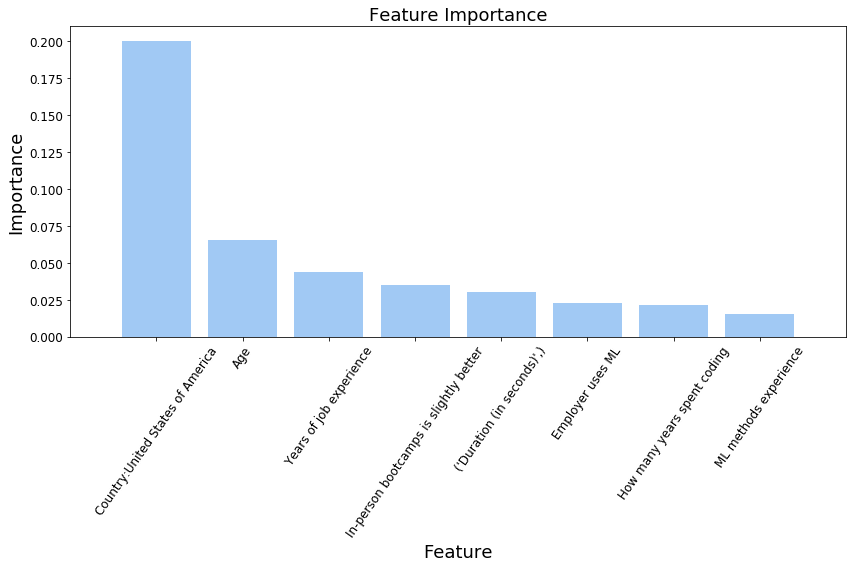

In [27]:
indices=indices[0:8]
feature_list=[]
for i in indices:
    feature_list.append(features_raw.columns[i])
features_importances = pd.DataFrame(features_raw,columns=feature_list)
plt.figure(figsize=(12,8))
plt.title('Feature Importance',size=18)
plt.bar(range(features_importances.shape[1]), 
        importances[indices],
        align='center')
 
plt.xticks(range(features_importances.shape[1]), 
           feat_labels[indices], rotation=55)
plt.xlim([-1, features_importances.shape[1]])
plt.ylabel("Importance", fontsize=18) 
plt.xlabel("Feature", fontsize=18)
plt.tick_params(labelsize=12)
plt.tight_layout()

##  Feature selection

Feature engineering is the act of extracting features from raw data and transforming them into formats that are suitable for the machine learning model. It is a crucial step in that feature engineering turn your inputs into things the algorithm can understand, and therefore enable the model to output results of higher quality. Practitioners agree that the vast majority of time in building a machine learning pipeline is spent on feature engineering and data cleaning.  

Since the "feature_importances_" help us find out the order of feature importance, why not use it to select the features? Some learning algorithms perform feature selection as part of their overall operation like random forest.Feature selection using random forest algorithm have good performance on many problems including non linear while another feature selection method, pearson correlation, is only sensitive to a linear relationship. In addition, random forest have relatively good accuracy, robustness and ease of use.

In [28]:
regressor = RandomForestRegressor(n_estimators=50, max_depth=100,max_features=550 ,random_state=0)
regressor.fit(features_raw, income_raw)
importances = regressor.feature_importances_
indices = np.argsort(importances)[::-1] 
feat_labels = features_raw.columns 
for feature in range(features_raw.shape[1]): 
    print("%2d) %-*s %f" % (feature + 1, 30, feat_labels[indices[feature]], importances[indices[feature]]))

 1) Country:United States of America 0.197605
 2) Age                            0.067081
 3) Years of job experience        0.044530
 4) ('Duration (in seconds)',)     0.031600
 5) How many years spent coding    0.024471
 6) Employer uses ML               0.018421
 7) ML methods experience          0.018218
 8) In-person bootcamps is slightly better 0.013786
 9) the number of favorite media sources 0.013113
10) No opinion aboout In person bootcamps 0.011316
11) Online learning is much better 0.010738
12) ('Q21_Part',)                  0.009917
13) Job title:Chief Officer        0.009573
14) ('In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice',)_Academics/Education 0.008863
15) ('How do you perceive the quality of online learning platforms and in-person bootcamps as compared to the quality of the education provided by traditional brick and mortar institutions? - Online learning platforms and MOOCs:',)_Neither better nor wors

Select features whose importance is greater than 0.001.

In [29]:
feature_list=[]
for i in indices[0:60]:
    feature_list.append(features_raw.columns[i])
selected_features = pd.DataFrame(features_raw,columns=feature_list)

The number of features is still high, which could cause complicated calculation in model implementation. In regression analysis, the larger the number of explanatory variables allowed, the greater is the chance of overfitting the model, producing conclusions that fail to generalise to other datasets. So I use PCA to reduce dimensionality.

In [30]:
def pca_reduce(df): 
    reduced_data=PCA(n_components=0.96).fit_transform(df)
    return reduced_data
selected_features = pca_reduce(selected_features)
selected_features = pd.DataFrame(selected_features)
selected_features.shape

(12364, 51)

In [31]:
#Split to train and test set
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(selected_features, income_raw, test_size=0.3, random_state=42)

# Model Implementation
 
### Baseline Models
To begin with, I will train some baseline models (models with default values) to a get a baseline to beat. These models are 'Decision Tree','KNeighborsRegressor', 'Lasso' and 'Random Forest'. 

Decision tree is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. I use it because there is no need to normalize the data and it works with both interval and categorical variables. But decision-tree learners can create over-complex trees that do not generalise the data well. This is called overfitting. 

In kNN regression, the output is the property value for the object. This value is the average of the values of its k nearest neighborsssified. This value is the average of the values of its k nearest neighbors. I choose the KNN algorithm in that it has no assumptions about data — useful, for example, for nonlinear data. But it is Computationally expensive — because the algorithm stores all of the training data.

The idea of Lasso is to add a penalty to the loss function and it will make our model not learning too perfect then cause overfitting. But it ignores nonsignificant variables that may, nevertheless, be interesting or important.

A random forest is a meta estimator that fits a number of decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. But the computational cost of training a random forest is quite low. 



Build two lists to store the mean and the standard deviation of the accuracy of each model respectively and We can view all the results in the dataframe that we created to store the values.

In [32]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict 
mean=[]
accuracy=[]
std=[]

In [33]:
kf = KFold(n_splits=10)
model=DecisionTreeRegressor() 
result_1 = cross_val_score(model,df_train_x, df_train_y, cv = kf,scoring = "r2")
mean.append(result_1.mean())
std.append(result_1.std())
accuracy.append(result_1)

In [34]:
kf = KFold(n_splits=10)
model = KNeighborsRegressor()
result_2 = cross_val_score(model,df_train_x, df_train_y, cv = kf,scoring = "r2")
mean.append(result_2.mean())
std.append(result_2.std())
accuracy.append(result_2)

In [35]:
from sklearn import linear_model
from sklearn.linear_model import Lasso
kf = KFold(n_splits=10)
model = linear_model.Lasso(alpha=0.01)
result_3 = cross_val_score(model,df_train_x, df_train_y, cv = kf,scoring = "r2")
mean.append(result_3.mean())
std.append(result_3.std())
accuracy.append(result_3)

In [36]:
kf = KFold(n_splits=10)
model = RandomForestRegressor(n_estimators=10)
result_4 = cross_val_score(model,df_train_x, df_train_y, cv = kf,scoring = "r2")
mean.append(result_4.mean())
std.append(result_4.std())
accuracy.append(result_4)

In [37]:
model=['Decision Tree','KNeighborsRegressor', 'Lasso','Random Forest']
models_accuracy=pd.DataFrame({'Decision_Tree':accuracy[0],'KNeighborsRegressor':accuracy[1],'Lasso':accuracy[2],'Random_Forest':accuracy[3]})       
models_accuracy

,Decision_Tree,KNeighborsRegressor,Lasso,Random_Forest
0,-0.218491,0.342941,0.324815,0.372270
1,-0.181189,0.359631,0.374723,0.306153
2,-0.099240,0.351435,0.430961,0.392615
3,0.035336,0.408033,0.500624,0.468980
4,-0.064349,0.384534,0.396934,0.352498
5,-0.165355,0.354638,0.506897,0.382166
6,-0.095194,0.401532,0.489057,0.315830
7,-0.362270,0.370800,0.431956,0.304786
8,-0.082284,0.412464,0.411349,0.385848
9,-0.086043,0.366226,0.478319,0.413719


In [38]:
model=['Decision Tree','KNeighborsRegressor', 'Lasso','Random Forest']
models=pd.DataFrame({'Mean':mean,'Std':std},index=model)       
models

,Mean,Std
Decision Tree,-0.131908,0.101797
KNeighborsRegressor,0.375223,0.023701
Lasso,0.434564,0.056640
Random Forest,0.369487,0.049185


The accuracies are a liitle bit different across the folds for each model because different splits of training set and validation set will lead to different results.We can use the mean and the standard deviation  to evaluate the performance of the model. According to average and variance of accuracy for folds, Lasso model have the lowest bias and KNeighborsRegressor model have the lowest variance. The performance of Decision tree is the worst because the r2 is negative. All in all, Lasso performs best given the highest bias and the variance that are not low.

Let's tune hyperparameters to improve the performance especially for Decision Tree.

# Model tuning

Improve the performance of the decision tree model with hyperparameter
tuning using grid search based on 'r2". The principle idea of GridSearchCv algorithm is to perform exhaustive search over specified parameter values for an estimator. It creates an n-space grid corresponding to the number of hyperparamters to tune and try every combination and implements a "fit" and a "score" method. Here I use R2 (coefficient of determination as the performance measure.

In [39]:
param_grid = { 
    'min_samples_split': np.arange(10,100,10),
    'min_samples_leaf': np.arange(10,100,10),
    'max_depth': [int(x) for x in np.arange(1,5)] + [None],
    }

clf=DecisionTreeRegressor()
grid_search=GridSearchCV(clf,param_grid,scoring = "r2") 
grid_search.fit(df_train_x, df_train_y) 
print('Best Estimator: ',grid_search.best_estimator_)
print('Highest r2: ',grid_search.best_score_)

Best Estimator:  DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=50,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
Highest r2:  0.27067876271606595


The r2 score of Decision Tree model is not negative any more.

Model 2: K-Nearest Neighbors

In [40]:
param_grid = {"n_neighbors": np.arange(3,10,1)}
knn_clf=KNeighborsRegressor()
grid_search_2=GridSearchCV(knn_clf,param_grid,scoring = "r2") 
grid_search_2.fit(df_train_x, df_train_y) 
print('Best Estimator: ',grid_search_2.best_estimator_.n_neighbors)
print('Highest r2: ',grid_search_2.best_score_)

Best Estimator:  8
Highest r2:  0.3781266298770955


Model 3: Lasso

In [41]:
from sklearn import linear_model
from sklearn.linear_model import Lasso
param_grid = {"alpha": [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 200,300,400,500]}
lasso=linear_model.Lasso(max_iter=50000)
grid_search_3=GridSearchCV(lasso,param_grid,scoring = "r2") 
grid_search_3.fit(df_train_x, df_train_y) 
print('Best Estimator: ',grid_search_3.best_estimator_)
print('Highest r2: ',grid_search_3.best_score_)

Best Estimator:  Lasso(alpha=200, copy_X=True, fit_intercept=True, max_iter=50000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Highest r2:  0.42926866077101616


Model 4: Random forest

In [42]:
param_grid = {'n_estimators': [int(x) for x in np.arange(10,100,10)]}
rf=RandomForestRegressor()
grid_search_4=GridSearchCV(rf,param_grid,scoring = "r2") 
grid_search_4.fit(df_train_x, df_train_y) 
print('Best Estimator: ',grid_search_4.best_estimator_)
print('Highest r2: ',grid_search_4.best_score_)

Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Highest r2:  0.41683025025198706


# Testing & Discussion

According to the R^2 of training set and test set, the performance of model improved after hyperparameter tuning. 

As we can see, the R^2 of training set is a little higher than that of test set but both overfitting and underfitting may cause the lower accuracy of test set.
In order to judge the goodness of fit and whether the model is overfitting or underfitting, we can plot the learning curve. Leaning curve can determine cross-validated training and test scores for different training set sizes. As we can see, training score and the cross-validation score are both not very good at the end and both of them converge to about 0.45, a low value which means the bias is still high. As a result, we can conclude that the model is underfitting.

### how to increase the accuracy?

According to the learning curve, we can find out we will not benefit much from more training data. We will probably have to use an better estimator or a parametrization of the current estimator that can learn more complex concepts (i.e. has a lower bias). We can improve the performance from a lot of aspects such as  feature selections, model implementation. 

In [43]:
optimal_model= linear_model.Lasso(alpha=200)
optimal_model.fit(df_train_x, df_train_y)
y_pred = optimal_model.predict(df_test_x)
y_train_pred = optimal_model.predict(df_train_x)
test_r2 = metrics.r2_score(df_test_y,y_pred)
train_r2 = metrics.r2_score(df_train_y,y_train_pred)

print('The R^2 of the test set is',test_r2)
print('The R^2 of the train set is',train_r2)

The R^2 of the test set is 0.42544102156023933
The R^2 of the train set is 0.44061545327091034


<module 'matplotlib.pyplot' from 'C:\\Users\\Administrator\\AppData\\Roaming\\Python\\Python35\\site-packages\\matplotlib\\pyplot.py'>

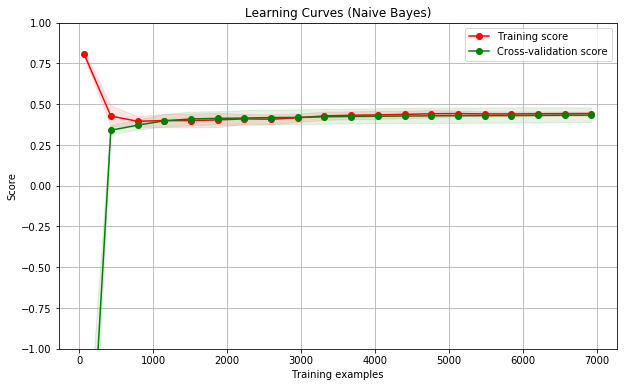

In [44]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.01, 1, 20)):
    plt.figure(figsize=(10,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,scoring = "r2")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = 5
estimator=linear_model.Lasso(alpha=100)
plot_learning_curve(estimator,title, df_train_x,df_train_y, ylim=(-1, 1), cv=cv, n_jobs=4)

# Reference

https://www.kaggle.com/shubhammank/what-do-data-scientists-earn-world-wide